## Recreational Facilities

My metric for determining the best neighborhood in Pittsburgh is the number of recreation facilities per neighborhood population. In this context, the term 'recreation facilities' refers to places where people can pursue hobbies and have fun, like pools, gyms, and rec centers. In my view, a good neighborhood is one that has plenty of opportunities to relax and meet new people. The ideal neighborhood should strike a happy medium between a high amount of both people and rec facilities.

For my metric, I'll be using the facilities and Pittsburgh population density datasets from the WPRDC, located here:

**Facilities:** https://data.wprdc.org/datastore/dump/fbb50b02-2879-47cd-abea-ae697ec05170

**Population Density 2010:** https://data.wprdc.org/dataset/40188e1c-6d2e-4f20-9391-607bd3054949/resource/8ac5c768-09ba-43a8-829f-ce4a417d20fb/download/population-density.csv

In [158]:
# Imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas as gd
%matplotlib inline

# Reading data
df = pd.read_csv("fac.csv")
pop = pd.read_csv("population-density.csv")
neighborhoods = gd.read_file("Neighborhoods/Neighborhoods_.shp")

In [159]:
df.head()

,id,parcel_id,inactive,name,rentable,type,primary_user,address_number,street,zip,...,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,650726265,120-J-300,f,57th Street Park Building,f,Storage,Department of Public Works,NaN,57TH ST,NaN,...,Upper Lawrenceville,7,10.0,42003101100,2.0,10.0,2.0,3-5,40.485658,-79.946446
1,783044037,2-H-284,f,Albert Turk Graham Park Shelter,f,Shelter,Department of Public Works,39.0,VINE ST,NaN,...,Crawford-Roberts,6,3.0,42003030500,3.0,3.0,2.0,2-1,40.440464,-79.984103
2,1997158435,23-R-157,f,Allegheny Northside Senior Center and Hazlett ...,t,Senior,CitiParks,5.0,ALLEGHENY SQ E,15212.0,...,Allegheny Center,1,22.0,42003562700,1.0,22.0,1.0,1-6,40.453091,-80.005339
3,204824684,10-F-198,f,Ammon Recreation Center,f,Pool,CitiParks,2217.0,BEDFORD AVE,15219.0,...,Bedford Dwellings,6,5.0,42003050900,3.0,5.0,2.0,2-5,40.448727,-79.977853
4,472140955,013-K-314,f,Arlington Field Lights Building,f,Utility,CitiParks,0.0,STERLING ST,15210.0,...,South Side Slopes,3,16.0,42003160800,3.0,16.0,3.0,4-22,40.418144,-79.974468


Facilities.csv is a fairly extensive dataset that has all sorts of information on a variety of facilities beyond recreational. Let's use this data to get an idea of the number of rec facilities in each neighborhood. The *type, neighborhood, inactive* columns should serve our purposes for now.

In [231]:
# Refine data. Remove inactive facilities
df = df[(df['inactive'] != 't')].dropna(subset=['inactive']).reset_index(drop=True)

#Create subset
df2 = df[['neighborhood','id']].groupby('neighborhood').count().rename(columns={'id':'facility_num'})

df2.head()

,facility_num
neighborhood,
Allegheny Center,4
Allegheny West,3
Allentown,3
Banksville,5
Bedford Dwellings,6


First, we filter out all facilities that are inactive. We then use .count() to get the total number of facilities for each neighborhood. Finally, we create a subset containing each neighborhood as well as their total facilities.

In [289]:
rec_areas = ['Pool', 'Rec Center', 'Shelter', 'Community', 'Pool/Rec', 'Activity']

#Calculate total number of recreational facilities in each neighborhood
df['num'] = 1
rec = df[['neighborhood','num']].loc[df['type'].isin(rec_areas)].groupby('neighborhood').count().rename(columns={'num':'rec_num'})

rec.head()

,rec_num
neighborhood,
Allegheny Center,2
Allentown,1
Banksville,2
Bedford Dwellings,1
Beltzhoover,2


Let's calculate the number of *recreational* facilities in each neighborhood. We can do this by filtering out rows in our original dataset that have facilities belonging to our filter, rec_areas. Then, we add them up by grouping by neighborhood and using .count(). 

The rec dataframe will come in handy when we work on the metric. For now, though, I'd like to use this data for visualization purposes.

,facility_num,rec_num
neighborhood,,
Squirrel Hill South,29,15
Highland Park,30,12
Perry North,20,9
Brookline,19,7
Mount Washington,7,5


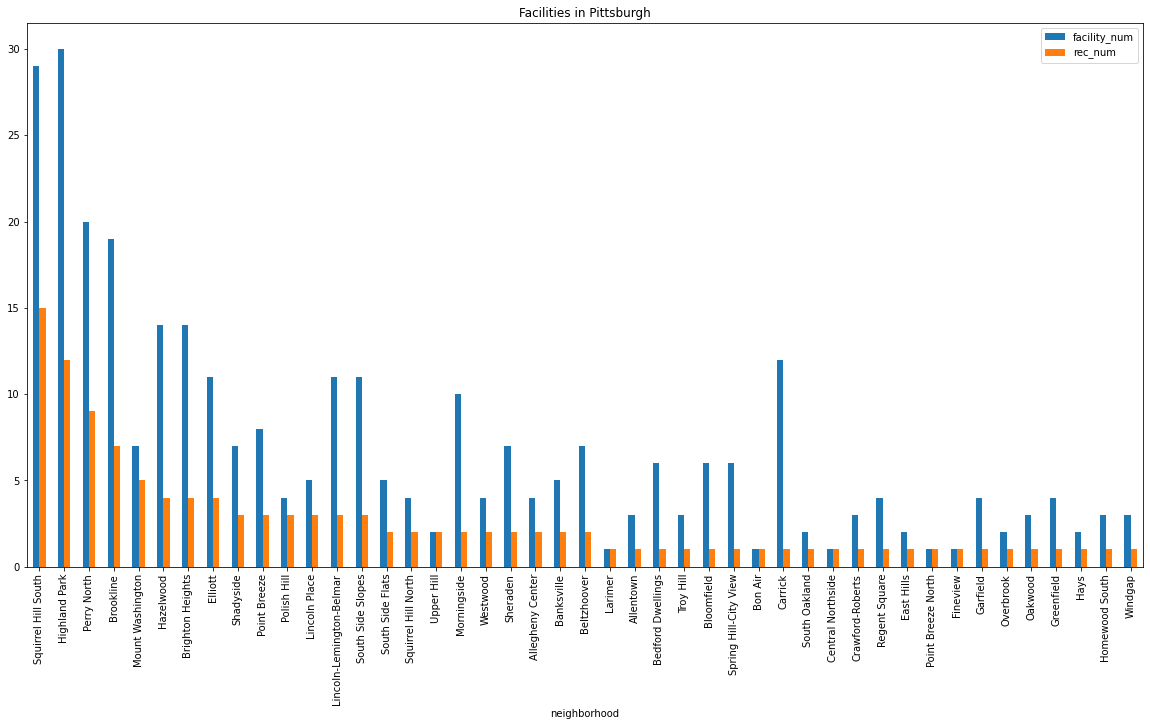

In [241]:
df3 = df2.merge(rec,on='neighborhood').sort_values('rec_num',ascending=False)
df3.plot.bar(figsize=(20,10), title='Facilities in Pittsburgh')

df3.head()

By merging the dataframes containing the total facilities as well as rec facilities on the common column of neighborhood, we can create an entirely new dataframe that helps us put the number of rec facilities in perspective. So far, Squirrel Hill South and Highland Park, among others, have high numbers of recreational facilities. 

<AxesSubplot:>

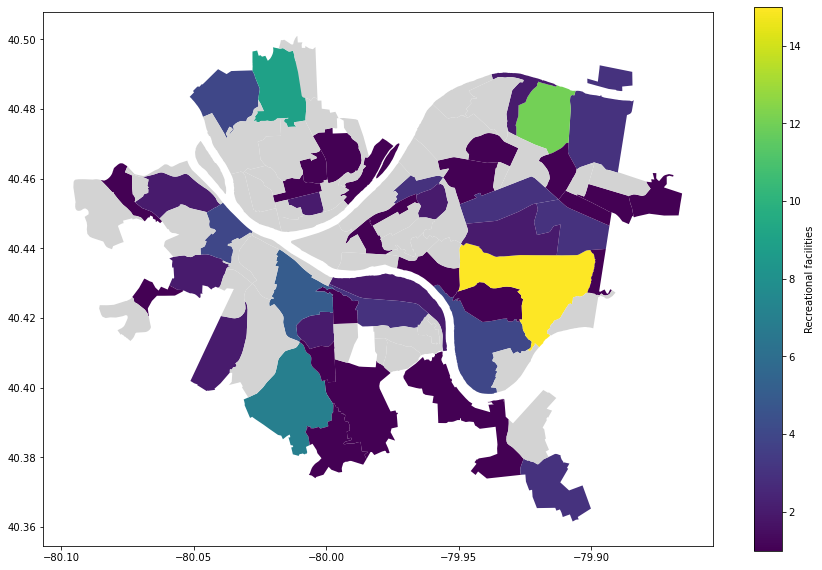

In [240]:
merged_hoods = neighborhoods.merge(rec, how='left', left_on='hood', right_on='neighborhood')

merged_hoods.plot(column='rec_num',
                  legend=True,
                  legend_kwds={'label':'Recreational facilities'},
                  figsize=(15,10),
                  missing_kwds={'color':'lightgrey'})


As an added bonus, here's a choropleth map of the number of rec facilities in each neighborhood. 

### The Metric

The metric being used to rank Pittsburgh's neighborhoods is based on the ratio of number of rec facilities to neighborhood population. 

In [292]:
# Create a subset of Pop density data and merge it with the number of rec facilities
pop = pop[['Pop. 2010','Neighborhood']]
df4 = rec.merge(pop, left_on='neighborhood',right_on='Neighborhood').rename(columns={'Pop. 2010':'pop'})

First, we create a subset of the population density data that contains the latest population data for each neighborhood, then merge it with the number of rec facilities in each neighborhood.

In [294]:
df4.head()

,rec_num,pop,Neighborhood
0,2,933,Allegheny Center
1,1,"2,500",Allentown
2,2,"4,144",Banksville
3,1,"1,202",Bedford Dwellings
4,2,"1,925",Beltzhoover


So far, so good! But the values in the *pop* column are of string type, which will cause problems when we use them for calculations later on. Let's convert these values to a usable type.

In [297]:
# Convert pop and num columns to float for calculation purposes
df4['pop'].replace(',','', regex=True, inplace=True)
df4 = df4.astype({'rec_num':'float','pop':'float'})

,Neighborhood,rec_num,pop,rec_ratio
0,Highland Park,12.0,6395.0,0.001876
1,Squirrel Hill South,15.0,15110.0,0.000993
2,South Side Slopes,3.0,4423.0,0.000678
3,Lincoln-Lemington-Belmar,3.0,4883.0,0.000614
4,Mount Washington,5.0,8799.0,0.000568
5,Point Breeze,3.0,5315.0,0.000564
6,Brighton Heights,4.0,7247.0,0.000552
7,Brookline,7.0,13214.0,0.000530
8,Sheraden,2.0,5299.0,0.000377
9,South Side Flats,2.0,6597.0,0.000303


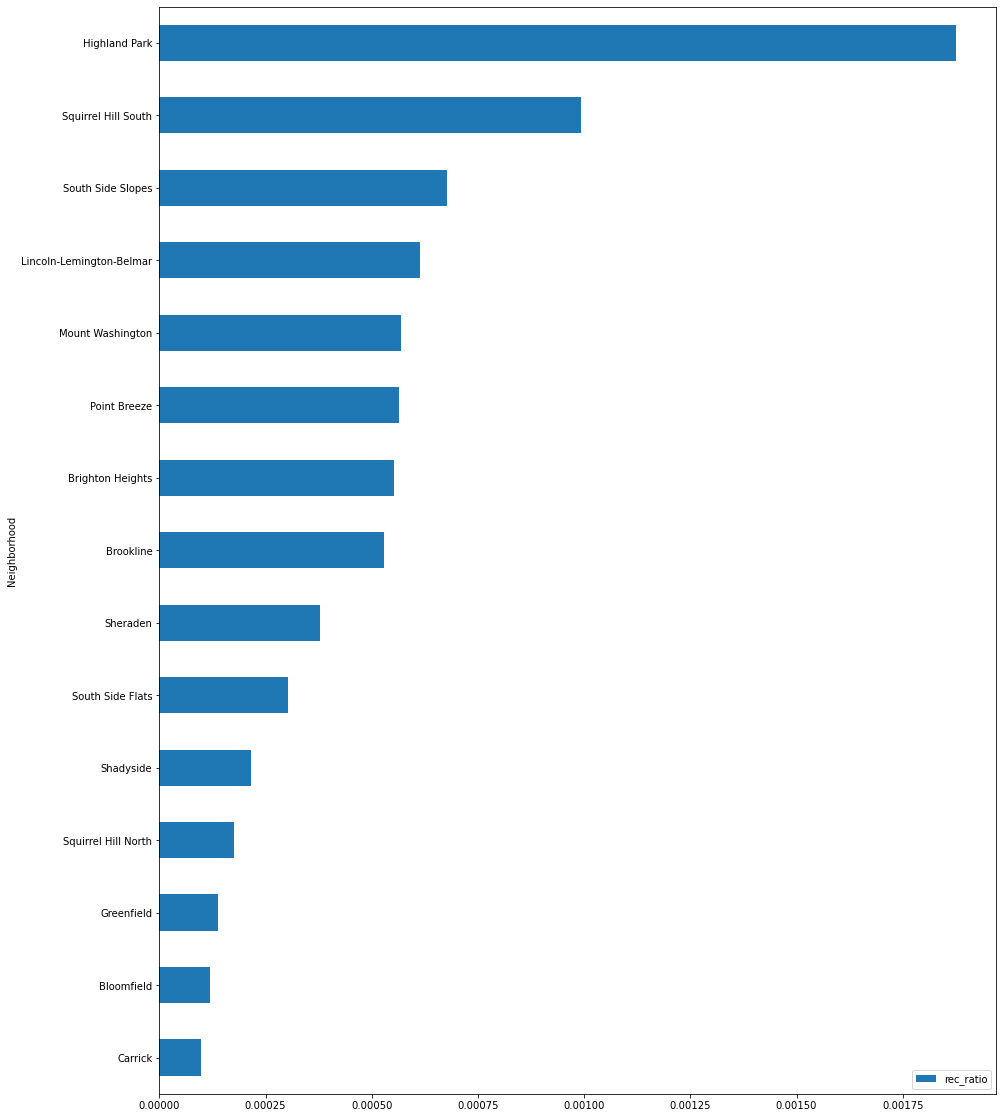

In [298]:
# Create new column with ratios
df4['rec_ratio'] = df4['rec_num']/df4['pop']

# Reorganize the dataframe and filter out neighborhoods with low populations
df4 = df4[['Neighborhood','rec_num','pop','rec_ratio']].sort_values('rec_ratio')
df4 = df4[df4['pop'] > df4['pop'].mean()]

# Plot!
df4.plot.barh(y='rec_ratio', x='Neighborhood', figsize=(15,20))

df4.sort_values('rec_ratio', ascending=False).reset_index(drop=True)

We create a column with rec facility ratios for each neighborhood, then filter out neighborhoods with low population levels (i.e., below the mean). Finally, we plot our data.

It can be seen that **Highland Park** comes out on top, followed by Squirrel Hill South, South Side Slopes, Lincoln-Lemington-Belmar and Mount Washington.